# Future weather models 

Create synthetic future weather data up to 2100 by using climate projections by DWD: 

https://www.dwd.de/DE/klimaumwelt/klimaatlas/klimaatlas_node.html;jsessionid=D84E870D1392681BE23498BDEFDD6364.live11043

1. Baseline model: no change relative to 1971-2000 average
2. Reserved model: slight changes
3. T-model: only T-changes, pronounced
4. P-model: only P-changes, pronounced
5. Mid model: Intermediate changes in P and T
6. Worst-case model: Extreme changes in P and T

Always calculate anomalies relative to baseline model.

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

pd.set_option('display.max_rows', 100)


## Load data

In [3]:
w = pd.read_csv('./data/weather_collections/weather_daily_region.csv')

# change date column to datetime type
w.date = pd.to_datetime(w.date)

# restrict data to the reference period 1971-2000
w = w.loc[w['date'] >= pd.to_datetime('1971-01-01')]
w = w.loc[w['date'] <= pd.to_datetime('2000-12-31')]

# set datetime index
w.set_index('date', inplace=True)
#w['date'] = w.index
w

,station_id_count,precip_mean,precip_min,precip_max,precip_std,tmean_mean,tmean_min,tmean_max,tmean_std,tmax_mean,...,tmax_max,tmax_std,tmin_mean,tmin_min,tmin_max,tmin_std,moisture_mean,moisture_min,moisture_max,moisture_std
date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,7,0.028571,0.0,0.2,0.075593,-11.385714,-13.5,-10.2,1.175342,-6.228571,...,-4.4,1.443046,-14.471429,-17.5,-12.7,1.715337,83.000000,80.0,87.0,3.162278
1971-01-02,7,0.400000,0.0,1.0,0.424264,-8.042857,-9.3,-7.4,0.723089,-6.257143,...,-5.5,0.475595,-14.828571,-17.5,-12.1,1.829129,82.333333,79.0,88.0,3.076795
1971-01-03,7,0.757143,0.2,2.0,0.618755,-5.857143,-6.5,-4.7,0.699660,-4.628571,...,-2.7,1.338798,-8.242857,-10.1,-7.3,1.008063,86.500000,84.0,93.0,3.271085
1971-01-04,7,0.128571,0.0,0.5,0.179947,-5.414286,-6.2,-4.7,0.636209,-4.057143,...,-2.5,0.832380,-6.171429,-7.3,-5.2,0.809762,88.000000,84.0,94.0,3.794733
1971-01-05,7,0.000000,0.0,0.0,0.000000,-9.100000,-12.7,-7.3,1.940790,-5.414286,...,-4.0,0.971989,-11.357143,-15.0,-8.6,2.428894,87.666667,85.0,91.0,2.658320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,5,1.320000,0.0,1.9,0.828855,4.520000,4.0,5.2,0.540370,6.820000,...,8.2,0.861394,1.360000,0.2,2.6,1.080740,95.000000,93.0,98.0,2.000000
2000-12-28,5,0.060000,0.0,0.2,0.089443,3.100000,0.0,4.3,1.752142,5.920000,...,6.8,0.653452,1.260000,-1.5,2.7,1.697940,78.200000,71.0,90.0,7.596052
2000-12-29,5,4.280000,3.0,6.5,1.347961,0.160000,-1.4,1.0,0.928978,2.560000,...,3.9,1.663731,-1.060000,-2.1,0.0,0.756968,95.200000,92.0,97.0,1.923538


<Axes: xlabel='date', ylabel='tmean_mean'>

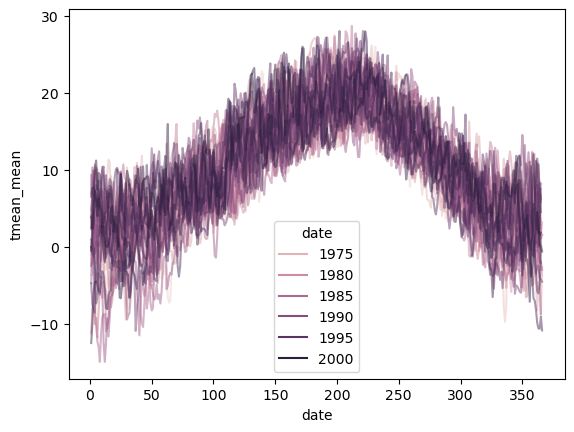

In [4]:
sns.lineplot(data=w, x=w.index.dayofyear, y='tmean_mean',
             hue=w.index.year,
             alpha=0.5)
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))
#plt.xlim(0,365)

## Create reference year from average

First iteration only with average values. Later try more elaborate calculations.

In [5]:
ref_year = w.groupby(by=[w.index.month.rename('month'),
                         w.index.day.rename('day')]
                    ).agg({'precip_mean': 'mean',
                          'moisture_mean': 'mean',
                          'tmean_mean': 'mean',
                          'precip_std': 'std',
                          'moisture_std': 'std',
                          'tmean_std': 'std',})

ref_year.reset_index(inplace=True)

In [6]:
ref_year['month'] = ref_year['month'].astype(str).str.zfill(2)
ref_year['day'] = ref_year['day'].astype(str).str.zfill(2)
ref_year['month_day'] = ref_year['month'] + '-' + ref_year['day']

In [7]:
#ref_year.info()

In [8]:
#ref_year['precip_mean']

In [9]:
#ref_year['precip_std'].quantile(0.05)#.median()

## Create scenario: Reference year, no drift

In [10]:
s_name = 'avg_t0_p0' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 0#2/100 # °C absolute change per year
y2y_p_change = 0#0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [11]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2000-01-01,2000-01-01,0.938165,84.921627,-0.045476,1.122057,1.814339,0.349213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02,2000-01-02,1.056786,86.353730,1.060932,1.543725,1.748377,0.466580,1.994950,0.507728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,2000-01-03,2.358497,82.955595,1.658455,1.221580,1.836179,0.386965,3.415283,1.359694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,2000-01-04,0.096581,83.210635,1.481820,2.122723,1.974659,0.466672,2.455078,1.570138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,2000-01-05,2.319830,82.913690,2.080144,1.430935,2.911046,0.497324,2.416410,1.780982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-12-27,2049-12-27,2.461917,83.405556,1.886021,1.444886,1.511458,0.448116,3.512060,2.297806,13.007696,2.594140,68.528072,2.767241,189.166509,6.102295,708.964467,10.095885,2132.396812,10.099128
2049-12-28,2049-12-28,1.291032,83.336786,2.667842,0.934792,1.952753,0.443350,3.752948,2.276931,13.385872,2.651688,67.221528,2.733469,188.108931,5.993589,709.235883,10.097081,2129.372405,10.100126
2049-12-29,2049-12-29,1.736834,84.247024,1.854800,1.809798,2.530036,0.461310,3.027866,2.261321,13.113129,2.498689,66.378911,2.675602,188.430693,5.867876,707.495199,10.097388,2127.875265,10.100843


(10957.0, 11322.0)

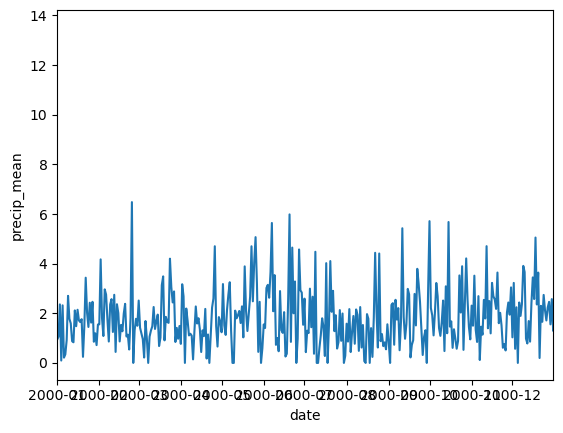

In [12]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [13]:
s = s[s.index.dayofweek == 0]
#s

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,2.358497,82.955595,1.658455,1.221580,1.836179,0.386965,3.415283,1.359694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,2000-01-10,1.777650,85.923651,2.252069,1.465449,2.591032,0.560551,4.479705,1.657621,8.374481,1.450763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-17,2000-01-17,1.712776,82.487143,0.412686,1.303699,3.816420,0.963622,3.854268,1.487371,10.750868,1.131608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-24,2000-01-24,1.449745,85.237738,2.397504,1.436624,1.978102,0.556138,3.475339,2.601569,12.061178,1.700062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,2000-01-31,1.546969,81.736667,1.475136,0.902554,2.688088,0.442663,2.264882,1.718618,10.823603,1.974377,45.425413,1.550569,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-11-29,2049-11-29,2.579450,86.856190,3.590790,1.426920,2.222422,0.458727,5.177026,3.635904,11.832751,3.314518,56.937794,5.121985,178.725762,9.891124,704.968555,10.098916,2133.420687,10.103726
2049-12-06,2049-12-06,1.953980,84.449167,2.653696,1.258352,2.028689,0.438305,3.264741,3.402381,11.558165,2.752515,56.730481,4.201809,175.912533,8.855404,707.420237,10.099350,2133.557387,10.102282
2049-12-13,2049-12-13,1.122660,82.059286,2.938975,1.127052,3.493577,0.706457,3.500702,2.518237,16.374805,3.149182,60.632941,3.503805,179.176910,7.915921,708.672475,10.093553,2130.675976,10.100813


(10957.0, 11322.0)

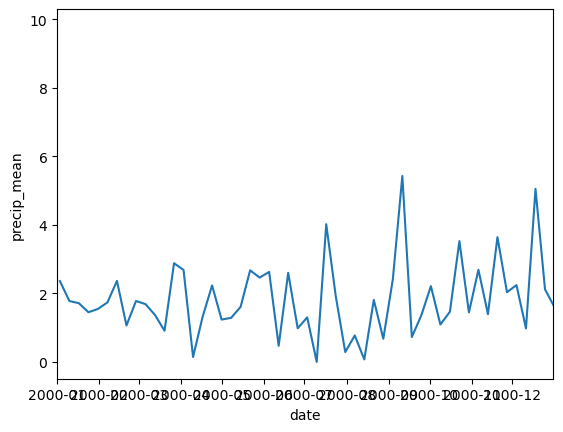

In [14]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [15]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From reference year, strong pos drift

In [16]:
s_name = 'avg_t+4_p+10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 4/100 # °C absolute change per year
y2y_p_change = 0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [17]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

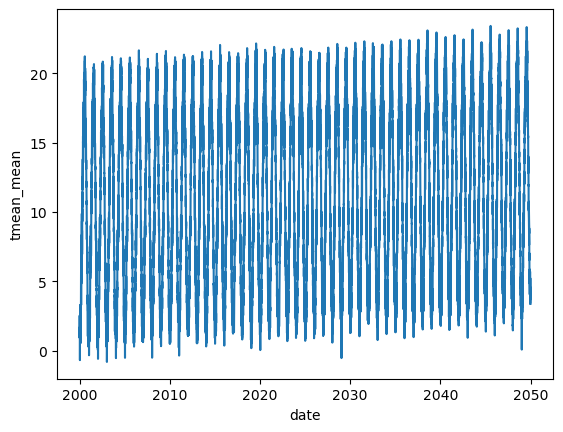

In [20]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [21]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

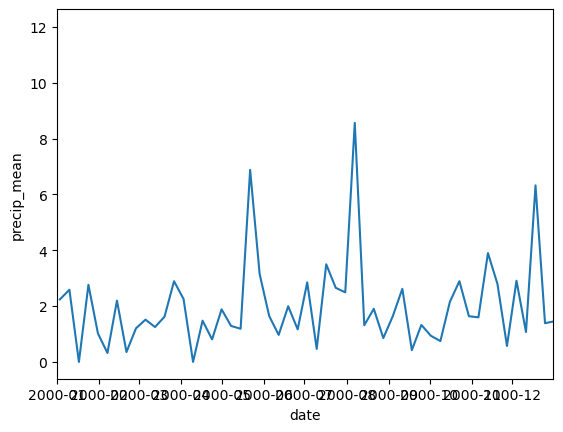

In [22]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [23]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From reference year, weak pos drift

In [24]:
s_name = 'avg_t+2_p+05' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 2/100 # °C absolute change per year
y2y_p_change = 0.05/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [25]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

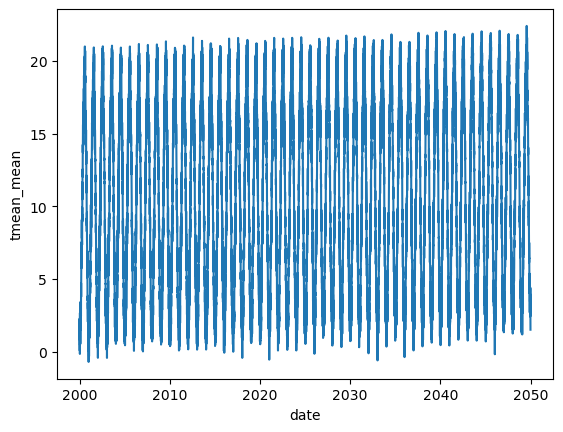

In [26]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [27]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

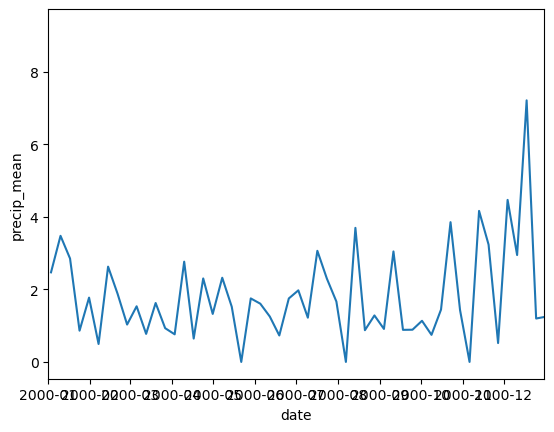

In [28]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [29]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From ref year, +T, -P

In [30]:
s_name = 'avg_t+4_p-10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 4/100 # °C absolute change per year
y2y_p_change = -0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [31]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

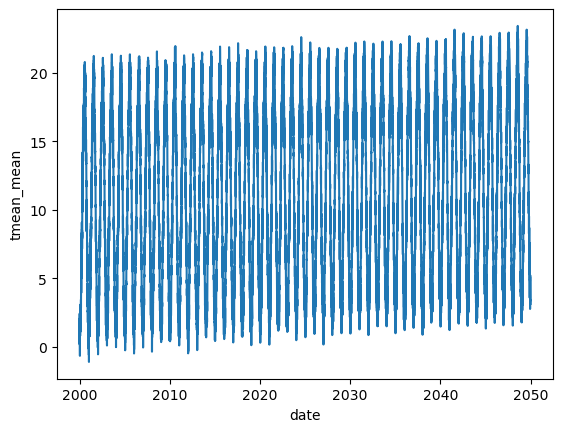

In [32]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [33]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

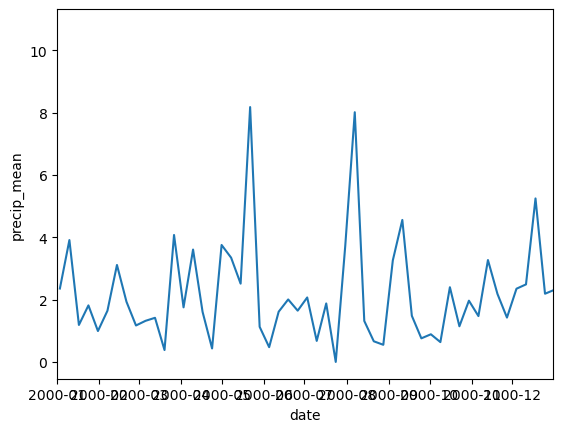

In [34]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [35]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From ref year, -T, +P

In [36]:
s_name = 'avg_t-4_p+10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = -4/100 # °C absolute change per year
y2y_p_change = 0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [37]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

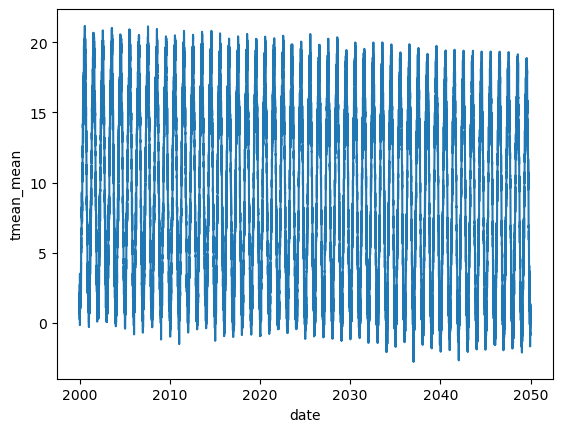

In [38]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [39]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

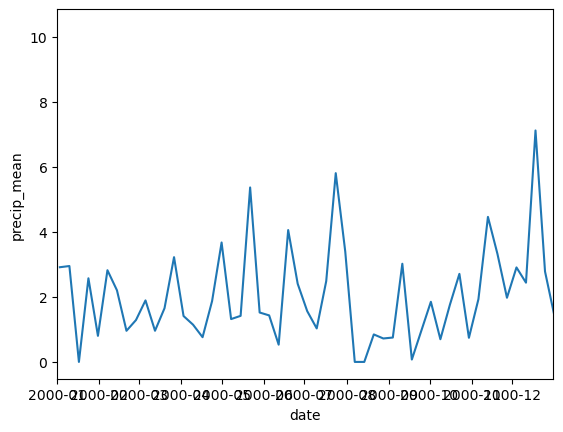

In [40]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [41]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)